# UUbar discrimination using GNN (Graph-level classification) 

## import packages

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

## data preparation

In [2]:
final_df = pd.read_csv('uubar.csv')
print(final_df.keys())
print(final_df.keys().shape[0])
print(final_df.shape)
final_df.head()

Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'jet_type'],
      dtype='

,subjetpT0,subjetpT1,subjetpT2,subjetpT3,subjetpT4,subjeteta0,subjeteta1,subjeteta2,subjeteta3,subjeteta4,...,Q_5_1,Q_6_0,Q_6_0.3,Q_6_0.5,Q_6_0.7,Q_6_1,charge ratio,jet_charge,charge_asymmetry,jet_type
0,7.058072,6.358462,5.186489,3.016375,2.201581,0.635624,0.630064,1.781071,1.627017,0.598289,...,0.720338,3.0,2.132549,1.704354,1.365958,0.985341,0.00,4.0,1.0,1.0
1,10.199473,9.963601,4.735384,2.891007,1.930021,2.157630,2.096738,1.965430,1.932615,2.183731,...,0.267088,4.0,2.872018,2.302883,1.846531,1.325817,1.00,0.0,0.0,1.0
2,6.062532,4.461598,3.889703,2.881487,1.816467,0.244864,-1.244864,-1.257961,0.155314,-1.272724,...,0.083019,-1.0,-0.714273,-0.544719,-0.398251,-0.223039,0.75,-1.0,0.0,1.0
3,14.102426,4.117096,4.083389,3.087446,2.920695,0.659219,-0.053328,0.527523,-0.196722,-0.222644,...,-0.410227,3.0,1.719858,1.143315,0.723160,0.301215,2.00,2.0,0.0,1.0
4,6.714681,4.381626,2.881419,1.330680,0.507379,-0.807633,-0.916532,-0.945381,-0.847256,-0.940951,...,0.426104,5.0,3.871013,3.263831,2.751888,2.130519,0.00,1.0,0.0,1.0


In [40]:
import torch
from torch_geometric.data import Data

# Node features: Specify features for each node
node_feature_cols = [
    'subjetpT0', 'subjeteta0', 'subjetphi0', 'subjetcharge0', 'subjetmt0',
    'subjetpT1', 'subjeteta1', 'subjetphi1', 'subjetcharge1', 'subjetmt1',
    'subjetpT2', 'subjeteta2', 'subjetphi2', 'subjetcharge2', 'subjetmt2',
    'subjetpT3', 'subjeteta3', 'subjetphi3', 'subjetcharge3', 'subjetmt3',
    'subjetpT4', 'subjeteta4', 'subjetphi4', 'subjetcharge4', 'subjetmt4'
]

# Graph-level features: Add these as extra features for all nodes
graph_level_features = [
       'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry'
]

# Label: 'jet_type' (binary classification: up quark or anti-up quark)
labels_col = 'jet_type'

# Extract features and labels
num_nodes = 5
X_node_features = final_df[node_feature_cols].values.reshape(-1, 5, 5)  # Shape: (num_graphs, num_nodes, node_features_per_node)
X_graph_features = final_df[graph_level_features].values  # Shape: (num_graphs, graph_features_per_graph)
y_labels = final_df[labels_col].values  # Shape: (num_graphs,)

# Create graph data objects
data_list = []
for i in range(len(X_node_features)):
    # Node features: Concatenate graph-level features to each node
    node_features = torch.tensor(X_node_features[i], dtype=torch.float)  # Shape: (5, 5)
    graph_features = torch.tensor(X_graph_features[i], dtype=torch.float).repeat(5, 1)  # Shape: (5, graph_features_per_graph)
    x = torch.cat([node_features, graph_features], dim=1)  # Shape: (5, 5 + graph_features_per_graph)

    # Edge index: Fully connected graph
    #edge_index = torch.combinations(torch.arange(x.size(0)), r=2).T  # Shape: (2, num_edges)
    edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j]).T


    # Label: Graph-level label
    y = torch.tensor([y_labels[i]], dtype=torch.long)  # Shape: (1,)

    # Create a Data object for the graph
    data_list.append(Data(x=x, edge_index=edge_index, y=y))


In [42]:
print(data_list[0])
print(len(data_list[0]))    # x, edge_index and y attribute
if True:
    dataset = data_list[0]
    # Basic Information
    print("Number of nodes:", dataset.num_nodes)
    print("Number of features per node:", dataset.num_node_features)
    print("Node feature matrix shape:", dataset.x.shape)
    print("Node labels shape:", dataset.y.shape)
    print("Edge index shape:", dataset.edge_index.shape)

    # Example inspection of the data
    print("\nExample node feature matrix:")
    print(dataset.x[:1])  # Show features for the first 5 nodes

    print("\nExample edge index:")
    print(dataset.edge_index[:, :20])  # Show the first 5 edges

    print("\nNode labels:")
    print(dataset.y.item())  # Show labels for the first 10 nodes

Data(x=[5, 48], edge_index=[2, 20], y=[1])
3
Number of nodes: 5
Number of features per node: 48
Node feature matrix shape: torch.Size([5, 48])
Node labels shape: torch.Size([1])
Edge index shape: torch.Size([2, 20])

Example node feature matrix:
tensor([[7.0581, 0.6356, 0.6541, 0.0000, 0.0000, 2.0000, 1.4609, 1.1892, 0.9708,
         0.7199, 2.0000, 2.2287, 2.4301, 2.6787, 3.1592, 2.0000, 1.4609, 1.1892,
         0.9708, 0.7199, 2.0000, 2.2287, 2.4301, 2.6787, 3.1592, 0.4000, 0.5623,
         0.6506, 0.7209, 0.7983, 0.4000, 0.5623, 0.6506, 0.7209, 0.7983, 2.0000,
         1.4612, 1.1896, 0.9713, 0.7203, 3.0000, 2.1325, 1.7044, 1.3660, 0.9853,
         0.0000, 4.0000, 1.0000]])

Example edge index:
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]])

Node labels:
1


In [33]:
N_up = 0
N_antiup = 0
for data in data_list:
    if (data.y.item() == 1): N_up += 1
    if (data.y.item() == 0): N_antiup += 1

## Visualize Dataset

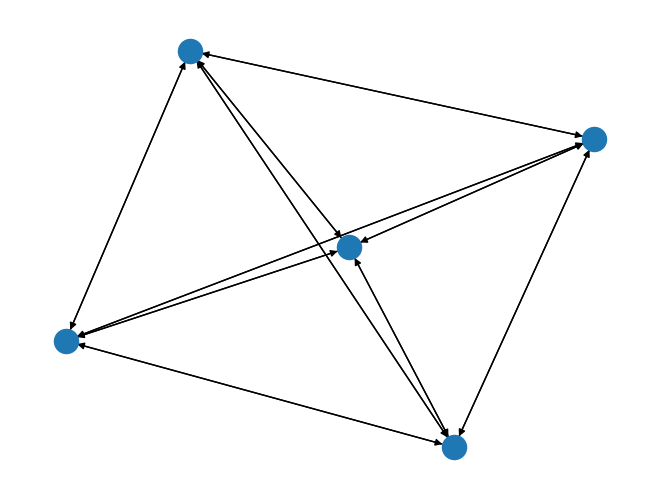

In [43]:
import networkx as nx
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt

def draw_graph(edge_index, gids=[]):
  src = edge_index[0].tolist()
  dst = edge_index[1].tolist()
  edges = [(s, d) for s, d in zip(src, dst)]
  G = nx.from_edgelist(edges)
  nx.draw(G)

#draw_graph(data_list[0].edge_index)
G = pyg_utils.to_networkx(data_list[0])
nx.draw(G)

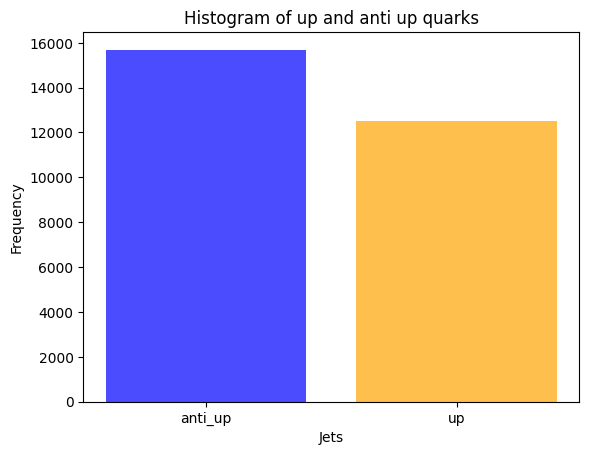

In [44]:
# Plot the histogram
values = ['anti_up', 'up']
frequencies = [N_antiup, N_up]

plt.bar(values, frequencies, color=['blue', 'orange'], alpha=0.7)
plt.title('Histogram of up and anti up quarks')
plt.xlabel('Jets')
plt.ylabel('Frequency')
plt.show()

## Split and DataLoader

In [45]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

# Split data into training and test sets
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

# Create DataLoader for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Number of training graphs: {len(train_data)}")
print(f"Number of test graphs: {len(test_data)}")

Number of training graphs: 22564
Number of test graphs: 5642


C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCNClassifier, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))  # Input to first hidden layer
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))  # Hidden layers

        self.fc = nn.Linear(hidden_dim, output_dim)  # Classification layer
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Pass through GCN layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Pooling: Summarize node features into graph-level embedding
        x = global_mean_pool(x, batch)

        # Classification layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [48]:
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = loss_fn(output, data.y)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accuracy
        pred = output.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            # Forward pass
            output = model(data)
            loss = loss_fn(output, data.y)
            total_loss += loss.item()

            # Accuracy
            pred = output.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [49]:
# Parameters
input_dim = data_list[0].x.shape[1]  # Number of input features per node
hidden_dim = 64  # Number of hidden units
output_dim = 2  # Binary classification: up vs anti-up quark
num_layers = 3  # Number of GCN layers
dropout = 0.5  # Dropout rate
epochs = 5  # Number of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, optimizer, and loss function
model = GCNClassifier(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

    print(f"Epoch {epoch+1:03d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 001: Train Loss: nan, Train Acc: 0.5562, Test Loss: nan, Test Acc: 0.5557
Epoch 002: Train Loss: nan, Train Acc: 0.5565, Test Loss: nan, Test Acc: 0.5557
Epoch 003: Train Loss: nan, Train Acc: 0.5565, Test Loss: nan, Test Acc: 0.5557
Epoch 004: Train Loss: nan, Train Acc: 0.5565, Test Loss: nan, Test Acc: 0.5557
Epoch 005: Train Loss: nan, Train Acc: 0.5565, Test Loss: nan, Test Acc: 0.5557


In [ ]:
# Count NaNs in each column and remove rows with NaN
NDIM = len(final_df.keys()) - 1
print("Number of features:", NDIM)
print("All features:", final_df.keys())

df_nonan = final_df.copy()
df_nonan = df_nonan.dropna()
#print(df_nonan.isna().sum())

dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]

# Preprocess the data: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create edge index for a fully connected graph
# For demonstration, a simple fully connected graph is created.
# In practice, you should create an edge_index based on your data's graph structure.
edge_index = torch.tensor(np.array([(i, j) for i in range(len(X)) for j in range(len(X)) if i != j]).T, dtype=torch.long)

# Convert data to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float)
Y_tensor = torch.tensor(Y, dtype=torch.long)

# Create a PyTorch Geometric data object
data = Data(x=X_tensor, edge_index=edge_index, y=Y_tensor)

# Split the data into training and testing sets
train_mask, test_mask = train_test_split(np.arange(len(Y)), test_size=0.2, random_state=42)

# Create masks for PyTorch Geometric
data.train_mask = torch.tensor(train_mask, dtype=torch.long)
data.test_mask = torch.tensor(test_mask, dtype=torch.long)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## GCN Model

In [ ]:
# GCN model to classify graph-level
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Create the model
model = GCN(in_channels=68, hidden_channels=16, out_channels=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test():
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.size(0)
    return acc

# Training loop
for epoch in range(50):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

# Final test accuracy
acc = test()
print(f'Final Test Accuracy: {acc:.4f}')


Epoch: 0, Loss: 0.6931, Test Accuracy: 0.5447
Epoch: 10, Loss: 0.6867, Test Accuracy: 0.5447
Epoch: 20, Loss: 0.6862, Test Accuracy: 0.5447
Epoch: 30, Loss: 0.6863, Test Accuracy: 0.5447
Epoch: 40, Loss: 0.6862, Test Accuracy: 0.5447
Final Test Accuracy: 0.5447
